Steane code
==========

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Perform a logical Hadamard

3. Peform a logical CX to entangle the two logical qubits 

4. Set up ancilla based on the parity matrix

5. Set up an error correcting circuit

5. Decode the qubit

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    get_noise,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_ERRORS = ['x', 'y', 'z', 'h', 's', 'sdg']
TWO_GATE_ERRORS = ['cx', 'cz']

FIRST_LOGICAL = True                     #Set up first logical qubit?
SECOND_LOGICAL = False                   #Set up second logical qubit?  NB, error correction is not possible with two logical qubits

FIRST_LOGICAL_X = False                  #Apply logical X operation? 
SECOND_LOGICAL_X = False                 #Apply logical X operation? 

FIRST_LOGICAL_H = False                  #Hadamard on first logical qbit
SECOND_LOGICAL_H = False                 #Hadamard on second logical qbit

FIRST_DECODE = True                      #Decode the first logical qubit
SECOND_DECODE = False                    #Decond the second logical qubit

REDUCED = True                           #Reduce the encoding circuit if possible

LOGICAL_CX = False                       #Logical CX
CX_CONTROL = 1                           #Logical control bit
CX_TARGET = 0                            #Logical target bit

CORRECT_ERROR = True                     #Correct errors
ANCILLAS = True                          #Ancillas are active?
MCT = True                               #Use MCT
EXTEND_ANCILLA = False                   #Correct errors (NB, can only do this with one logical QUBIT)
TESTING = True                           #Test by applying and X or Z error to one of the qubits
TEST_X_QUBIT = 0                         #Qbit to set bit flip- Starts at zero.
TEST_X_LOGICAL = 0                       #logical Qbit to set bit flip- Starts at zero.
TEST_Z_QUBIT = 6                         #Qbit to phase flip- Starts at zero.
TEST_Z_LOGICAL = 0                       #logical Qbit to set phase flip- Starts at zero.

NOISE = False                            #Test with noise
SHOTS = 10000                            #Number of shots to run    
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022

SIMULATOR = Aer.get_backend('qasm_simulator')

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


Create an instance of the logical qubits needed.  The parity check matrix above as an input.

The number of qubits needed is an argument to the class and should be 1 or 2 at present.

In [5]:
if SECOND_LOGICAL:
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, ANCILLAS, EXTEND_ANCILLA)
else:
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ANCILLAS, EXTEND_ANCILLA)

Use a method to initialise the logical qubits as a logical zero as required.

In [6]:
if FIRST_LOGICAL:
    qubit.set_up_logical_zero(0, REDUCED)
if SECOND_LOGICAL:
    qubit.set_up_logical_zero(1, REDUCED)
qubit.barrier()

If TESTING is active we test the ancilla with an X and Z error and check that the correct error syndrome is returned.

In [7]:
if TESTING:
    qubit.force_X_error(TEST_X_QUBIT,TEST_X_LOGICAL)   #force X error for testing
    #qubit.force_Z_error(TEST_Z_QUBIT,TEST_Z_LOGICAL)   #force Z error for testing
    qubit.barrier()

Set up ancilla and make a logical measurement

In [8]:
if ANCILLAS:
    qubit.set_up_ancilla(0)
    if SECOND_LOGICAL:
        qubit.set_up_ancilla(1)
    qubit.barrier()

Correct errors found in ancilla.  NB at present errors can only be corrected if one qubit is simulated due to memory constaints.

In [9]:
if CORRECT_ERROR:
    qubit.correct_errors(0, MCT)
    qubit.barrier()

Apply logical X gate

In [10]:
if FIRST_LOGICAL_X:
    qubit.logical_gate_X(0)
    qubit.barrier()
if SECOND_LOGICAL_X:
    qubit.logical_gate_X(1)
    qubit.barrier()

Apply logical Hadamard

In [11]:
if FIRST_LOGICAL_H:
    qubit.logical_gate_H(0)
    qubit.barrier()
if SECOND_LOGICAL_H:
    qubit.logical_gate_H(1)
    qubit.barrier()

Apply logical CX

In [12]:
if LOGICAL_CX:
    qubit.logical_gate_CX(CX_CONTROL,CX_TARGET)
    qubit.barrier()

Uncompute initialisation of logical qubit

In [13]:
if FIRST_DECODE:
    qubit.decode(0, REDUCED)
    if SECOND_DECODE:
        qubit.decode(1, REDUCED)
    qubit.barrier()

In [14]:
if NOISE:
    noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, SINGLE_GATE_ERRORS, TWO_GATE_ERRORS )

Measure qubits

In [15]:
qubit.logical_measure_data(0)
if ANCILLAS:
    qubit.logical_measure_ancilla(0)
if SECOND_LOGICAL:
    qubit.logical_measure_data(1)
    if ANCILLAS:
        qubit.logical_measure_ancilla(1)
qubit.barrier()

In [16]:
#Measurement noise
if NOISE:
    result = execute(qubit, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
else:
    result = execute(qubit, SIMULATOR, shots=SHOTS).result()

Execute results and print out.  The format is three bits for the X error address (logical Z), three bits for the Z error address (logical X) and seven bits for the Steane data bit. 

In [17]:
counts = result.get_counts(qubit)
print ('The different states can be counted.  The simulated result are', counts)

The different states can be counted.  The simulated result are {'100 000 0000000': 10000}


Print out circuit:

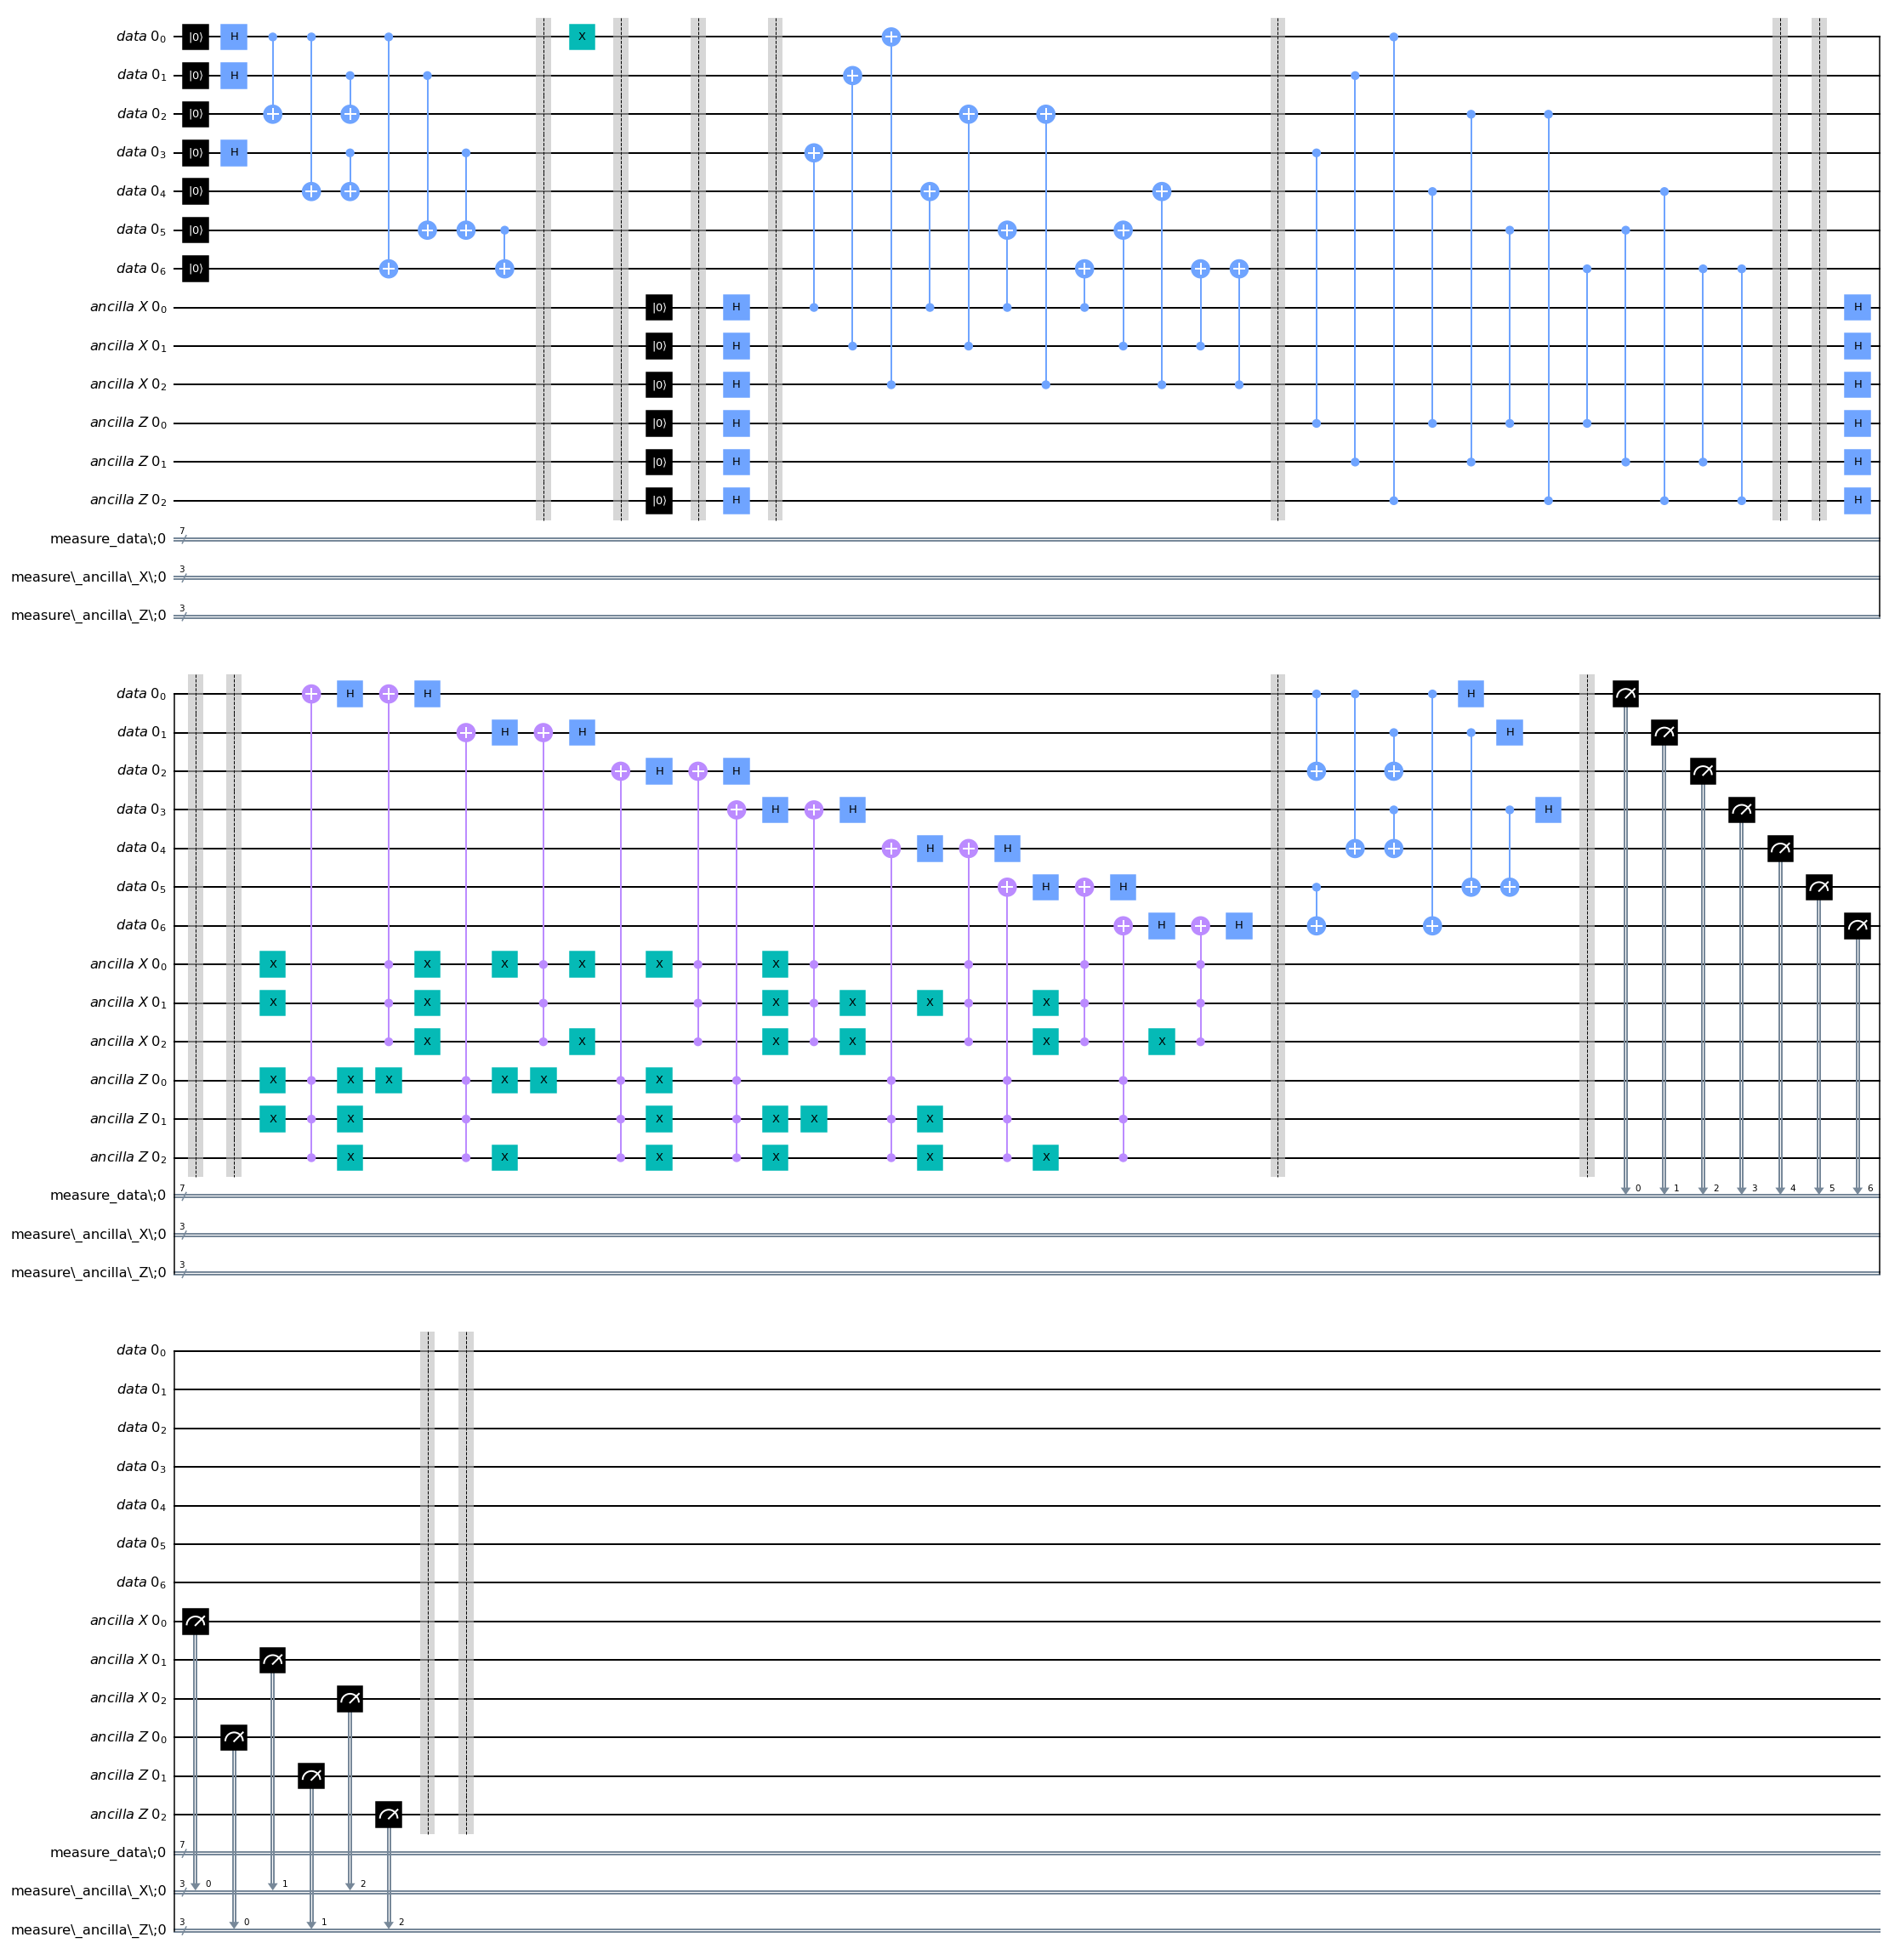

In [18]:
qubit.draw(output='mpl', filename = './circuits/Steane_code_circuit.jpg', fold = 44)